In [370]:
import pandas as pd
import numpy as np

data = pd.read_csv('data.csv')
print('Number of days',data['Date'].nunique())

Number of days 189


In [371]:
# Dictionary for activity label to integer conversion
activities = list(data['Activity'].unique())
data = pd.read_csv('train.csv')
act_to_ix = {activity:index for index, activity in enumerate(sorted(activities))}
#ix_to_act = {0: 'Bed_to_Toilet', 1: 'Eating', 2: 'Enter_Home', 3: 'Housekeeping', 4: 'Leave_Home', 5: 'Meal_Preparation', 6: 'Relax', 7: 'Sleeping', 8: 'Wash_Dishes', 9: 'Work'}
print(activities)
print(act_to_ix)

['Sleeping', 'Bed_to_Toilet', 'Meal_Preparation', 'Relax', 'Housekeeping', 'Eating', 'Wash_Dishes', 'Leave_Home', 'Enter_Home', 'Work']
{'Bed_to_Toilet': 0, 'Eating': 1, 'Enter_Home': 2, 'Housekeeping': 3, 'Leave_Home': 4, 'Meal_Preparation': 5, 'Relax': 6, 'Sleeping': 7, 'Wash_Dishes': 8, 'Work': 9}


In [372]:
def data_processing(dataframe, activity):
    starts = []
    durations = []
    activity_dataframe = dataframe[dataframe['Activity'] == activity].copy()
    activity_dataframe.index = np.arange(len(activity_dataframe))
    for i in range(len(activity_dataframe)):
        start = activity_dataframe['start hour'][i]*60 + activity_dataframe['start min'][i]
        end = activity_dataframe['end hour'][i]*60 + activity_dataframe['end min'][i]
  
        duration = end - start
        if duration < 0:
            duration += 1440
        starts.append(start)
        durations.append(duration)
    
    return starts, durations

starts, durations = data_processing(data,act_to_ix['Work'])

print(len(starts))
print(len(durations))

print(starts)
print(durations)

76
76
[947, 1075, 478, 807, 1340, 628, 1408, 1157, 592, 658, 1262, 680, 923, 970, 621, 735, 910, 558, 757, 713, 1043, 691, 932, 624, 858, 1010, 418, 830, 830, 863, 1086, 721, 942, 855, 713, 661, 923, 679, 665, 885, 1384, 889, 1028, 663, 601, 991, 764, 1077, 1329, 602, 1067, 653, 945, 1111, 868, 993, 946, 815, 927, 1036, 1084, 725, 670, 668, 634, 522, 455, 558, 595, 621, 517, 953, 454, 542, 789, 422]
[23, 2, 92, 3, 18, 2, 24, 84, 1, 10, 20, 3, 33, 28, 6, 52, 18, 4, 28, 71, 4, 321, 57, 3, 15, 19, 3, 31, 11, 16, 13, 4, 23, 30, 23, 2, 46, 35, 3, 112, 40, 29, 100, 11, 4, 1, 3, 8, 18, 2, 2, 19, 4, 4, 117, 55, 31, 55, 15, 25, 1, 133, 7, 21, 14, 20, 11, 6, 17, 30, 23, 20, 4, 45, 5, 8]


76


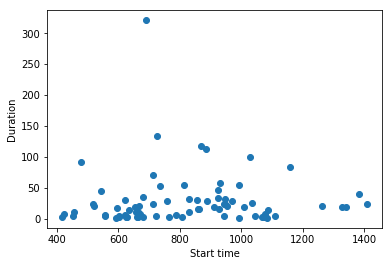

In [373]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(starts,durations)
plt.xlabel('Start time')
plt.ylabel('Duration')
print(len(starts))

In [374]:
from sklearn.cluster import KMeans

X = np.array([starts, durations]).T

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
center = kmeans.cluster_centers_

labels = kmeans.labels_

cluster1_indices = np.where(labels == 0)[0]
cluster2_indices = np.where(labels == 1)[0]

cluster1_data = []
for index in cluster1_indices:
    cluster1_data.append(X[index,:])
    
cluster2_data = []
for index in cluster2_indices:
    cluster2_data.append(list(X[index,:]))

cluster1_data = np.array(cluster1_data)
cluster2_data = np.array(cluster2_data)

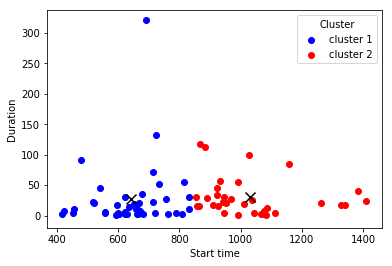

In [375]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(cluster1_data[:,0],cluster1_data[:,1],color ='blue',label='cluster 1')
plt.scatter(cluster2_data[:,0],cluster2_data[:,1],color = 'red',label='cluster 2')
plt.xlabel('Start time')
plt.ylabel('Duration')
plt.scatter(center[0,0],center[0,1],color='black',marker='x',s=100)
plt.scatter(center[1,0],center[1,1],color='black',marker='x',s=100)
plt.legend(title='Cluster')
plt.show()

In [376]:
mean_cluster1 = np.mean(cluster1_data,axis=0)
std_cluster1 = np.std(cluster1_data,axis=0)
print(mean_cluster1)
print(std_cluster1)

[642.17073171  27.95121951]
[107.88202736  53.50539121]


In [377]:
mean_cluster2 = np.mean(cluster2_data,axis=0)
std_cluster2 = np.std(cluster2_data,axis=0)
print(mean_cluster2)
print(std_cluster2)

[1029.05714286   30.14285714]
[150.85848484  29.97250441]


In [378]:
def classifier(data_point):
    start, duration = data_point
    # Cluster 1 mean and std for start time and duration
    mean_start1 = mean_cluster1[0]
    mean_duration1 = mean_cluster1[1]
    
    std_start1 = std_cluster1[0]
    std_duration1 = std_cluster1[1]
    
    # Cluster 2 mean and std for start time and duration
    mean_start2 = mean_cluster2[0]
    mean_duration2 = mean_cluster2[1]
    
    std_start2 = std_cluster2[0]
    std_duration2 = std_cluster2[1]
    
    if ((mean_start1 - 2*std_start1) <= start <= (mean_start1 + 2*std_start1)) and ((mean_duration1 - 2*std_duration1) <= duration <= (mean_duration1 + 2*std_duration1)):
        classlabel = 1
    elif ((mean_start2 - 2*std_start2) <= start <= (mean_start2 + 2*std_start2)) and ((mean_duration2 - 2*std_duration2) <= duration <= (mean_duration2 + 2*std_duration2)):  
        classlabel = 2
        
    else:
        classlabel = 0
    
    return classlabel


In [379]:
normal_starts = np.load('normal_starts.npy')
abnormal_starts = np.load('abnormal_starts.npy')
durations = np.load('durations.npy')

In [380]:
results_abnormal = []
for i in range(len(normal_starts)):
    results_abnormal.append(classifier((abnormal_starts[i],durations[i])))

In [381]:
results_normal = []
for i in range(len(normal_starts)):
    results_normal.append(classifier((normal_starts[i],durations[i])))

In [382]:
mis_counter = 0
results_abnormal = np.array(results_abnormal)
#mis_counter += len(results_abnormal[results_abnormal != 0])
results_normal = np.array(results_normal)
mis_counter += len(results_normal[results_normal == 0])
accuracy = (len(abnormal_starts)*2 - mis_counter)/(len(abnormal_starts)*2)*100
accuracy = (len(starts) - mis_counter)/len(starts)*100
print(accuracy)

97.36842105263158


In [383]:
len(abnormal_starts)

21

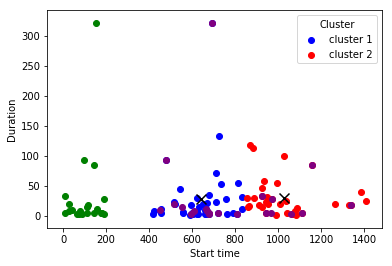

In [384]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(cluster1_data[:,0],cluster1_data[:,1],color ='blue',label='cluster 1')
plt.scatter(cluster2_data[:,0],cluster2_data[:,1],color = 'red',label='cluster 2')
plt.xlabel('Start time')
plt.ylabel('Duration')
plt.scatter(center[0,0],center[0,1],color='black',marker='x',s=100)
plt.scatter(center[1,0],center[1,1],color='black',marker='x',s=100)
plt.scatter(abnormal_starts,durations,color= 'green')
plt.scatter(normal_starts,durations,color='purple')
plt.legend(title='Cluster')
plt.show()

In [385]:
print(len(starts))
print(len(abnormal_starts))
print(len(durations))

76
21
21
